In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import country_converter as coco
import pypsa

import cartopy
import cartopy.crs as ccrs

from cartopy.io import shapereader


In [2]:
import cartopy.feature as cfeature

In [3]:
from matplotlib.lines import Line2D


In [5]:
from pypsa.plot import add_legend_patches


In [12]:
n2=pypsa.Network(r"./elec_s_256_lv1.25__Co2L0p29-6H-T-H-B-I-A-solar+p3-dist1_2030.nc")

INFO:pypsa.io:Imported network elec_s_256_lv1.25__Co2L0p29-6H-T-H-B-I-A-solar+p3-dist1_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


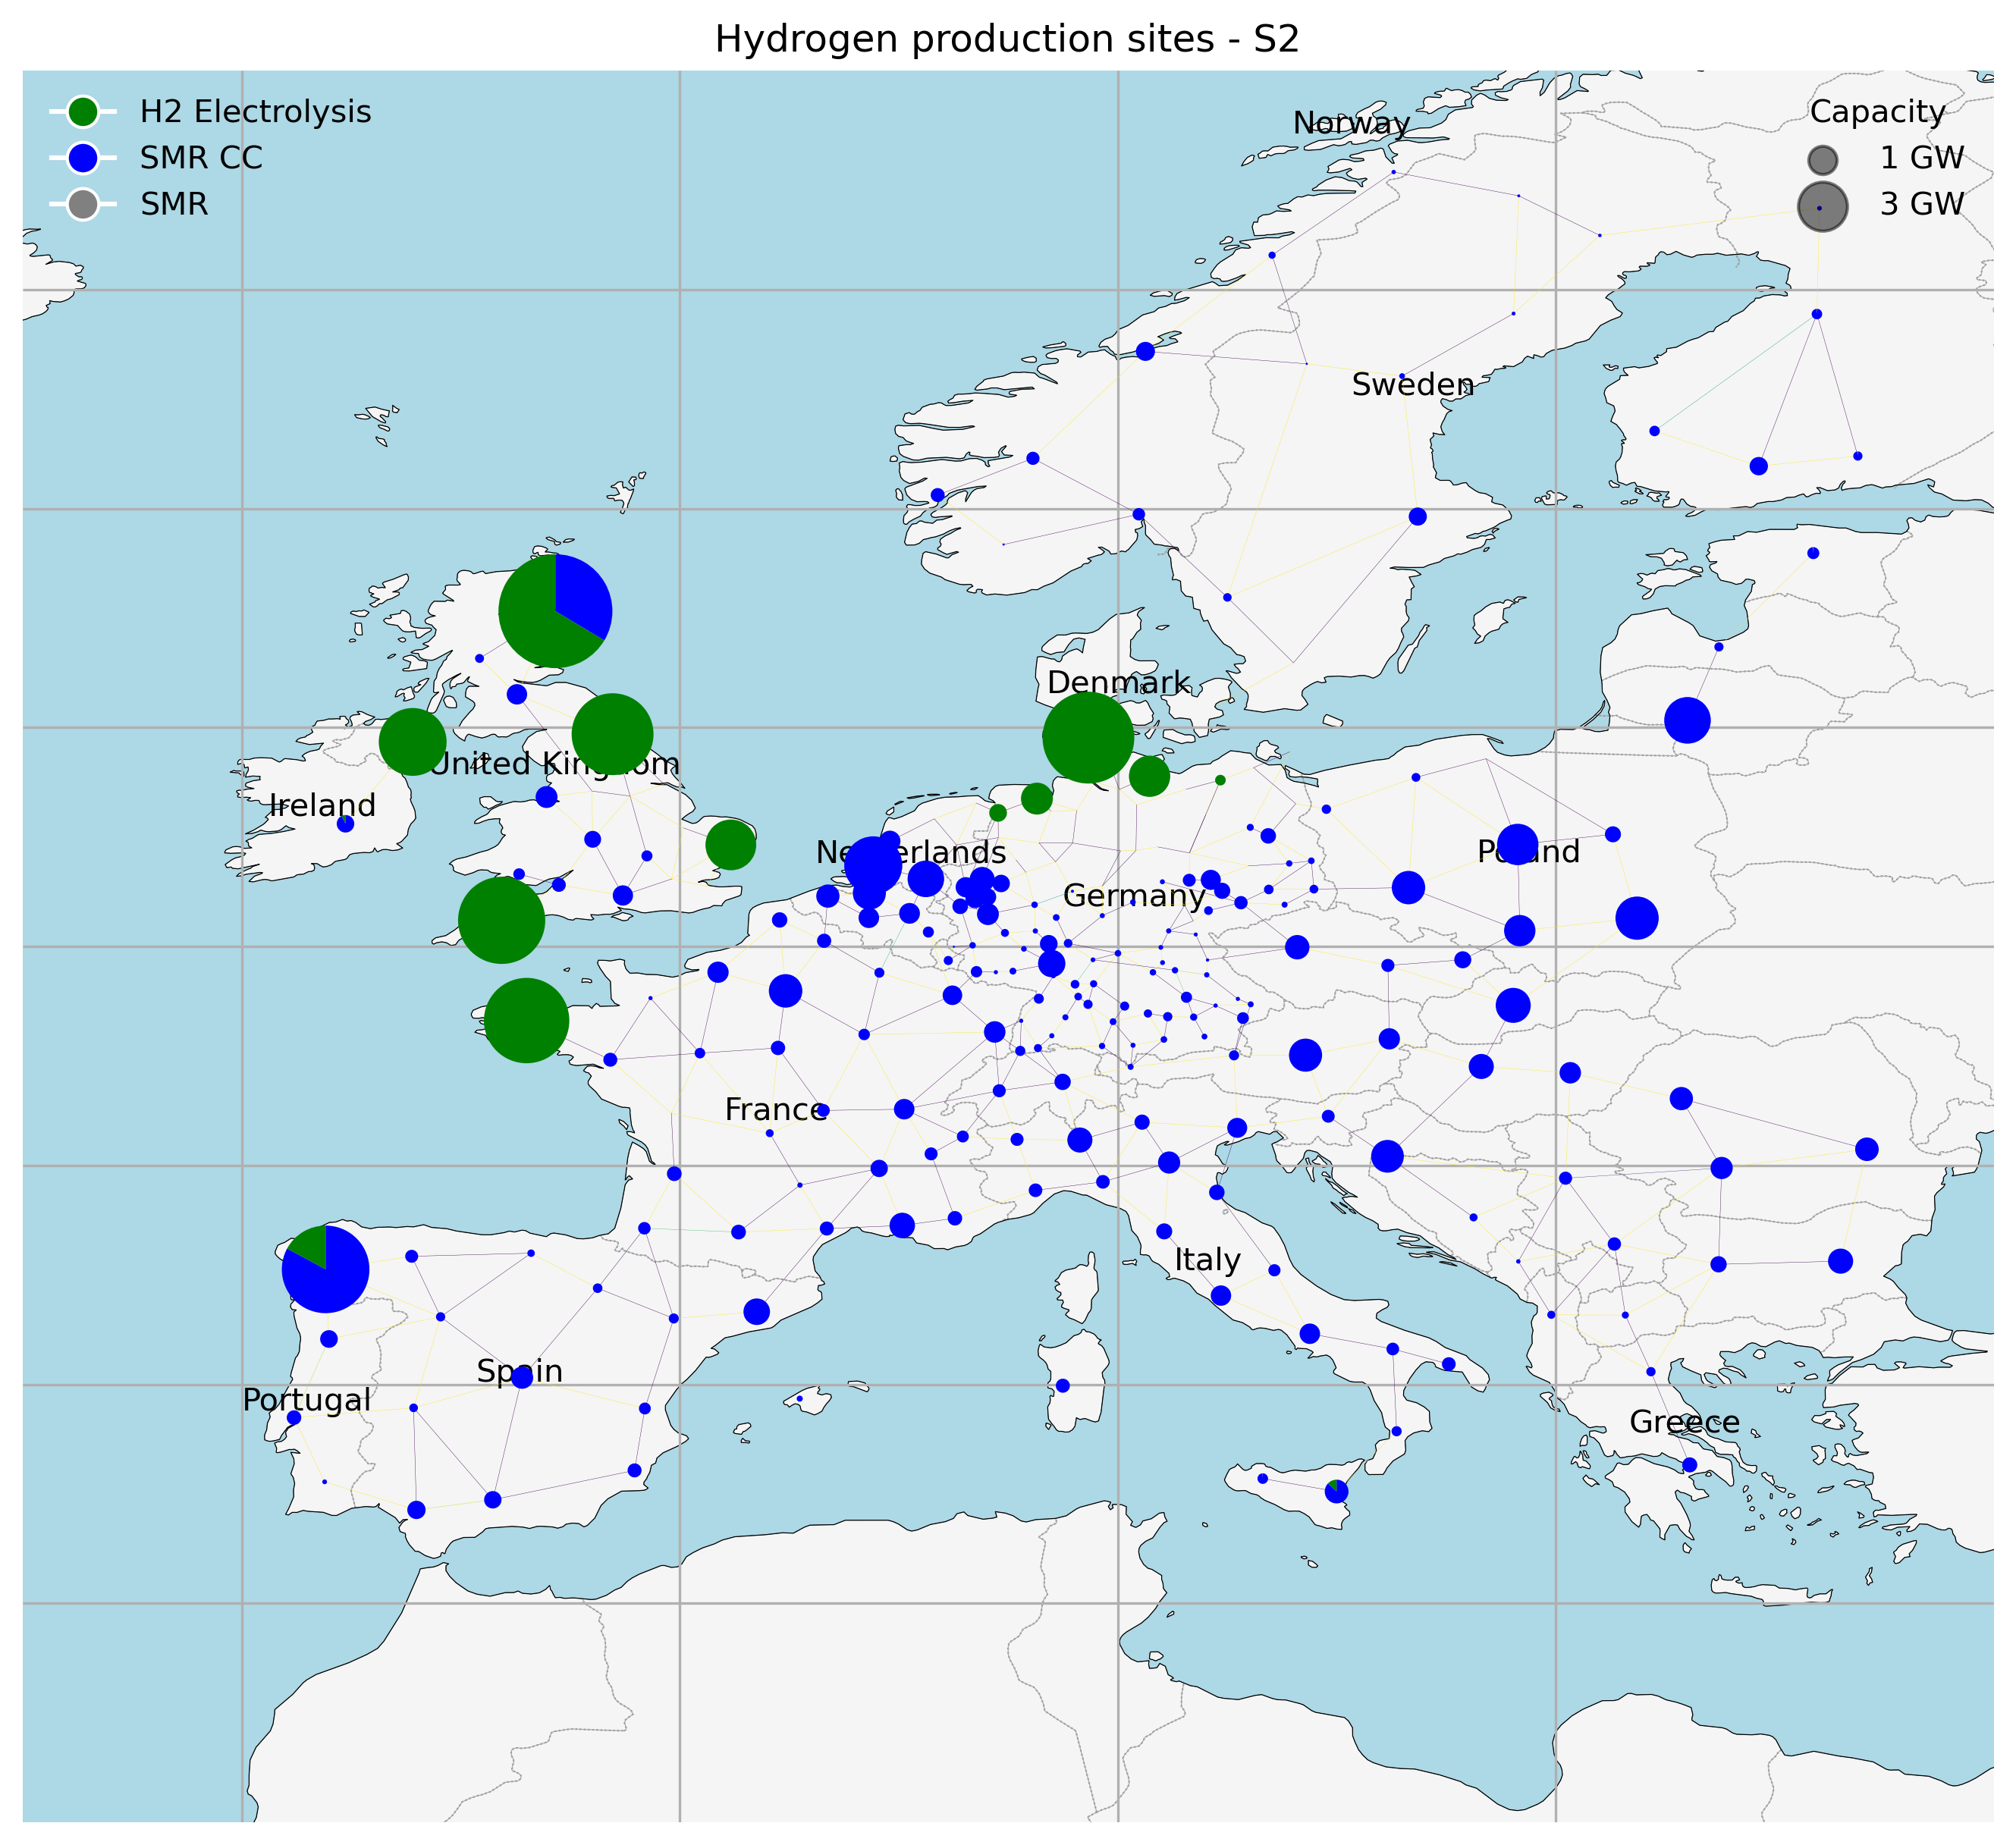

In [21]:
h2_sites2 = n2.links[n2.links.carrier.isin(["H2 Electrolysis", "SMR CC", "SMR"])].assign(l2=n2.links_t.p1.mean().abs()).groupby(["bus1", "carrier"]).l2.sum()
h2_sites2.index = h2_sites2.index.set_levels(h2_sites2.index.levels[0].str.replace(' H2', ''), level=0)

EUROPE_BOUNDS = [-15, 30, 30, 70]
carriers = ["H2 Electrolysis", "SMR CC", "SMR"]
colors = ["green", "blue", "gray"]

line_loading = n2.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

# Create a map with the PlateCarree projection centered on Europe

fig = plt.figure(figsize=(15, 10),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.LAND, linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linestyle=':', color="grey", linewidth=0.5)

# Additional code to add country names
# This requires the natural_earth package which contains shapefiles with country names and borders
# Assuming the shapefile is at the 50m resolution which is commonly used for maps at this scale
countries = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shapereader.Reader(countries)

# List of countries for which you want to display the full name
full_name_countries = ['Germany', 'Sweden', 'Denmark', 'Spain', 'France', 'Netherlands',
                       'Portugal', 'United Kingdom', 'Ireland', 'Italy', 'Greece', 'Poland', 'Norway']

# Define a function to check if a point is within the Europe bounds
def is_in_europe(x, y):
    lon_min, lon_max, lat_min, lat_max = EUROPE_BOUNDS
    return lon_min <= x <= lon_max and lat_min <= y <= lat_max

# Correct coordinates for France's label
france_label_coords = (2.2137, 46.2276) 

# Adding country names to the plot, but only for the specified European countries
for country in reader.records():
    geometry = country.geometry
    name_long = country.attributes['NAME_LONG']
    # Manually set France's label coordinates
    if name_long == 'France':
        x, y = france_label_coords
    else:
        x, y = geometry.centroid.x, geometry.centroid.y
    # Check if the country is in the list of specific countries
    if name_long in full_name_countries:
        ax.text(x, y, name_long, ha='center', va='center', fontsize=10, transform=ccrs.PlateCarree())



n2.plot(ax=ax,margin=0.25,
    bus_sizes=h2_sites2/3000,
    bus_colors={"H2 Electrolysis": "green", "SMR CC": "blue", "SMR": "gray"},
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="viridis",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    )

# Create legend for the energy mix size
for size in [1, 3]:  
    ax.scatter([], [], c='k', alpha=0.5, s=size * 80,
               label=str(size) + ' GW',  
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)


ax.legend(loc='upper right', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#plt.legend()
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Set extent for Europe
ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())

plt.title('Hydrogen production sites - S2')

plt.show()

In [15]:
h2_sites2.sort_values(ascending=False).head(15)

bus1    carrier        
GB0 13  H2 Electrolysis    3370.992106
DE1 72  H2 Electrolysis    3293.004254
GB0 11  H2 Electrolysis    2970.490143
FR1 3   H2 Electrolysis    2850.589272
GB0 8   H2 Electrolysis    2619.953104
ES1 5   SMR CC             2485.405947
GB5 0   H2 Electrolysis    1797.775643
GB0 13  SMR CC             1701.109418
NL1 1   SMR CC             1318.378623
GB0 14  H2 Electrolysis    1005.927263
LT6 0   SMR CC              848.826065
PL1 5   SMR CC              731.053604
PL1 3   SMR CC              669.400117
DE1 67  H2 Electrolysis     665.284357
NL1 2   SMR CC              522.410116
Name: l2, dtype: float64

In [13]:
h2_store.min()

2.2105173391369256e-06

/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


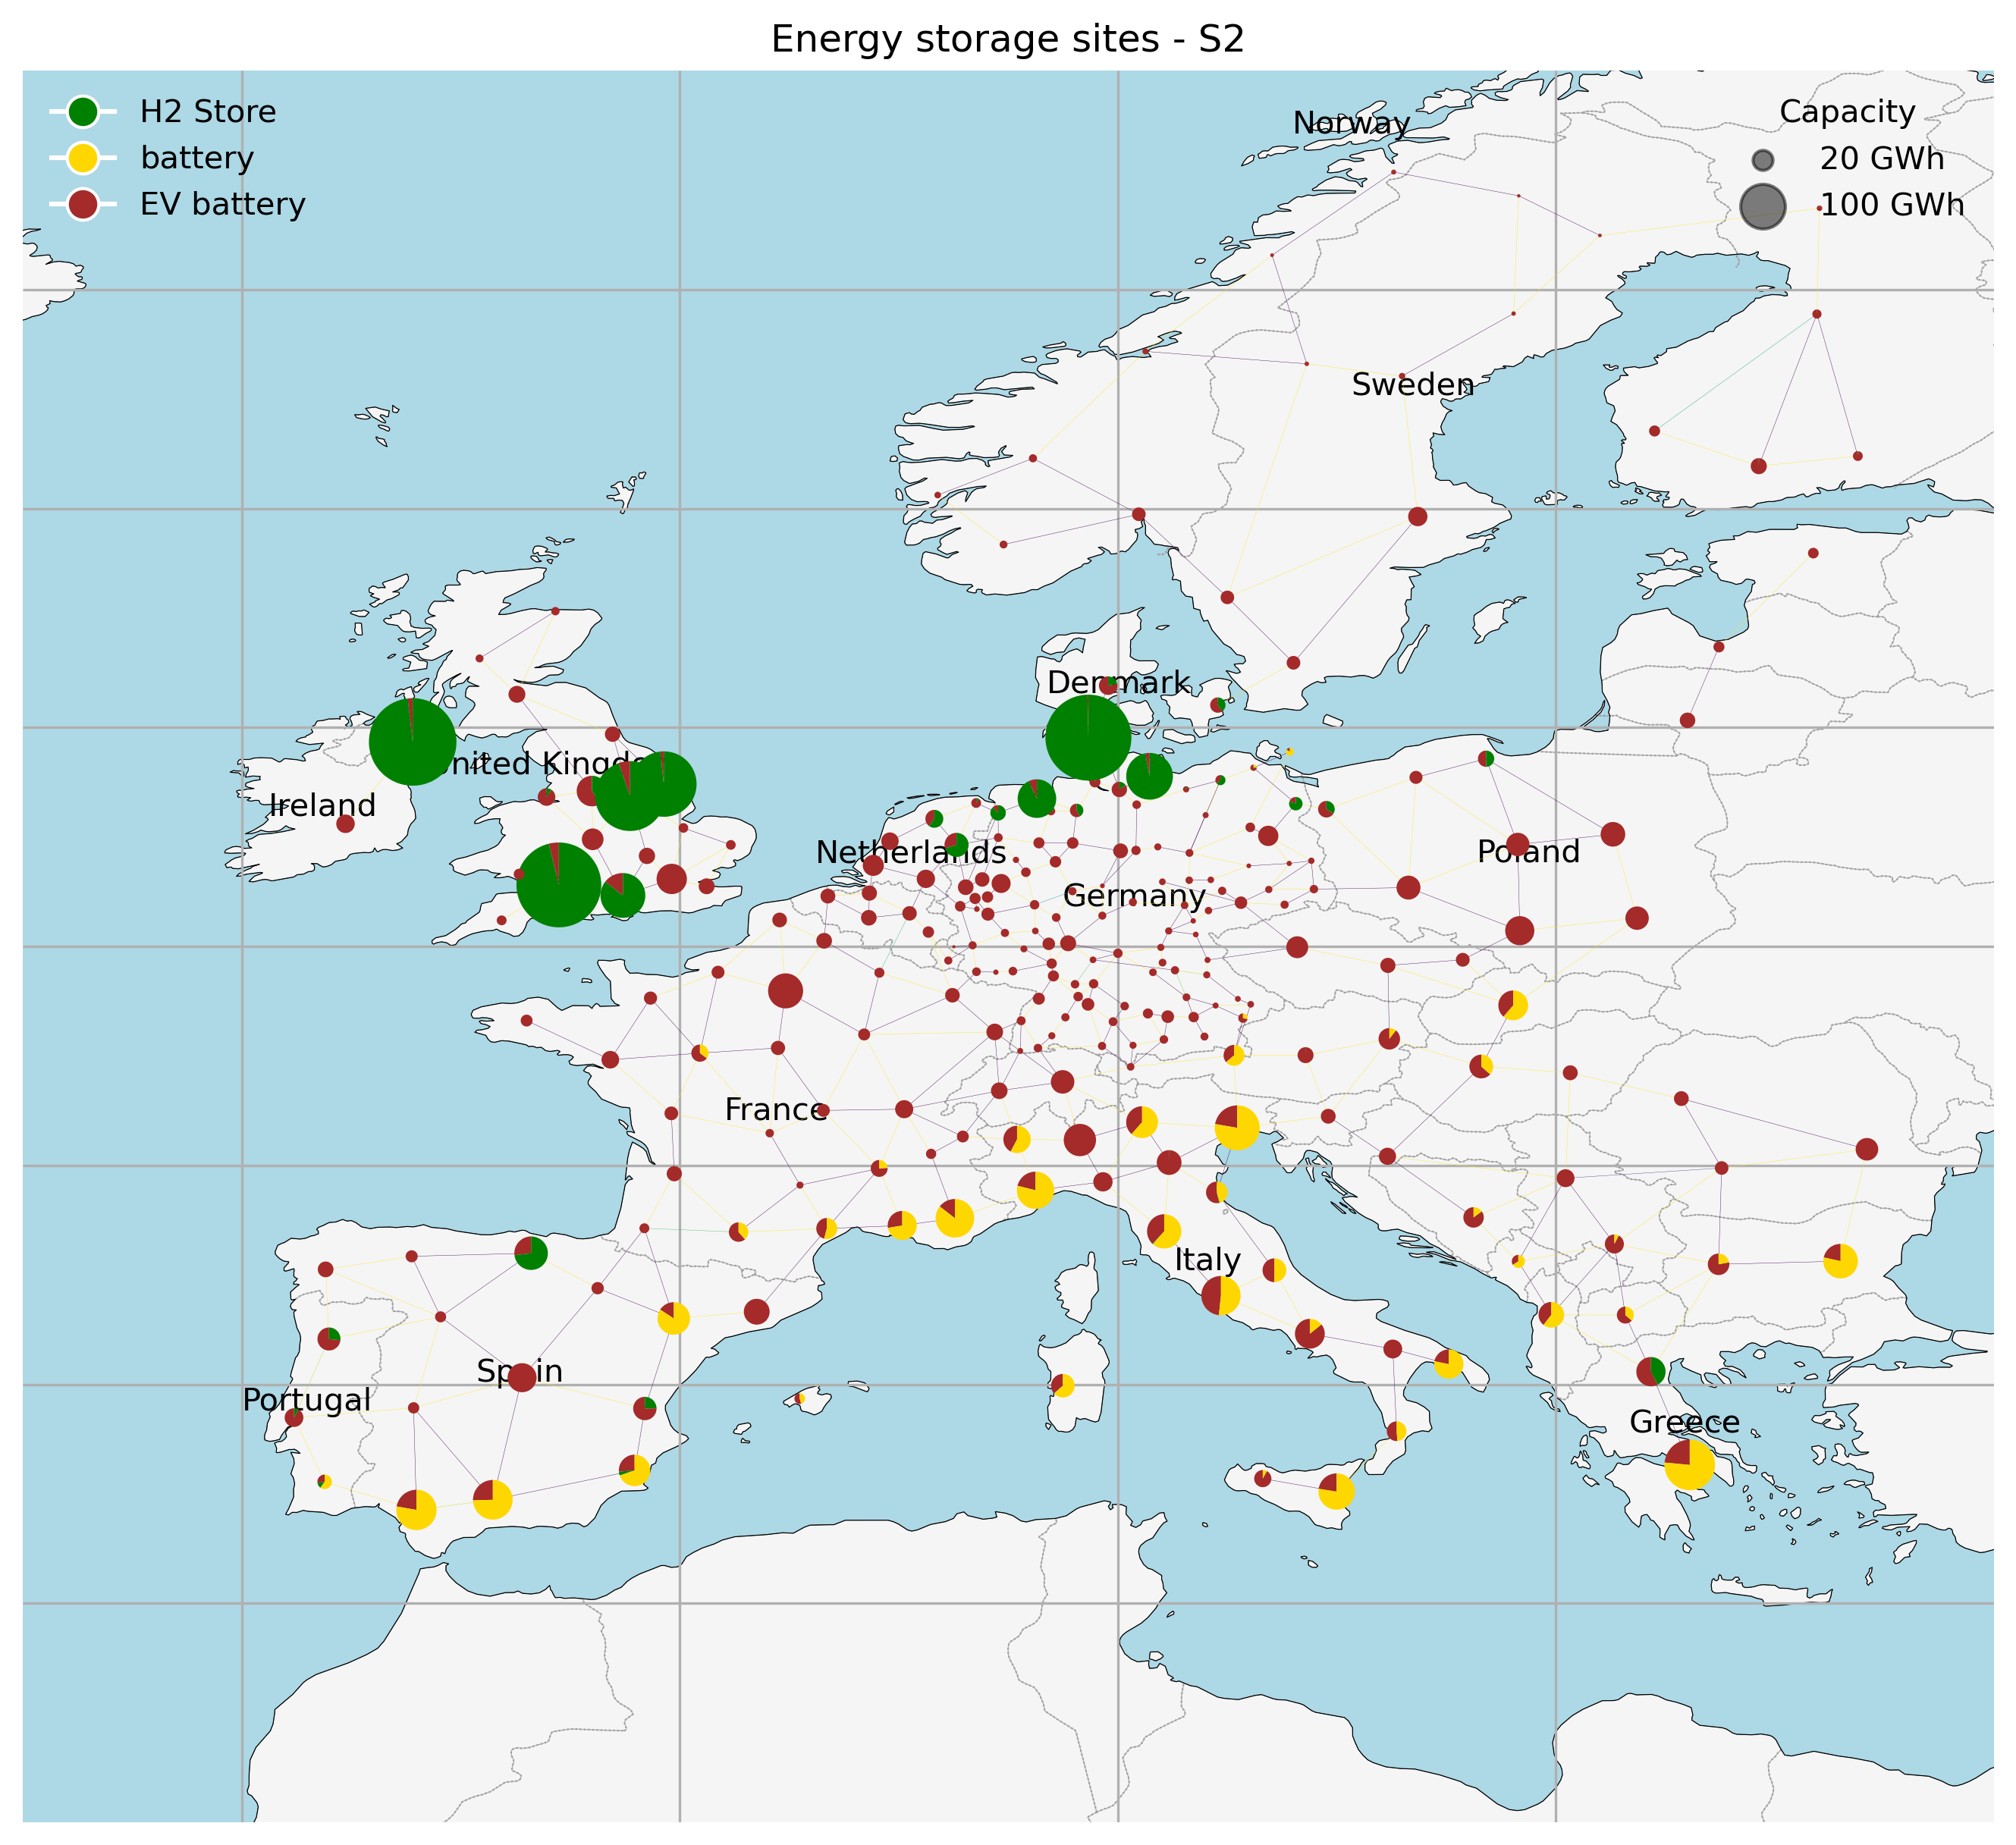

In [20]:
store = n2.stores[n2.stores.carrier.isin(["H2 Store", "battery", "battery storage"])].assign(sto3=n2.stores_t.e.mean()).groupby(["bus", "carrier"]).sto3.sum().div(1e3) #GWh
store = store.reset_index()

# Perform the regular expression extraction on the 'bus' column
store ['bus'] = store['bus'].str.extract(r'(\w+\s+\d+)', expand=False)

# Set the modified 'bus' column back as part of the multi-index
store = store.set_index(['bus', 'carrier'], drop=True)

series = store["sto3"]
series.index = series.index.set_levels(series.index.levels[1].str.replace('battery storage', 'EV battery'), level='carrier')



EUROPE_BOUNDS = [-15, 30, 30, 70]
#carriers = ["H2 Electrolysis", "SMR CC", "SMR"]
carriers = ["H2 Store", "battery", "EV battery"]

colors = ["green", "gold", "brown"]

line_loading = n2.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

# Create a map with the PlateCarree projection centered on Europe

fig = plt.figure(figsize=(15, 10),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.LAND, linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linestyle=':', color="grey", linewidth=0.5)

# Additional code to add country names
# This requires the natural_earth package which contains shapefiles with country names and borders
# Assuming the shapefile is at the 50m resolution which is commonly used for maps at this scale
countries = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shapereader.Reader(countries)

# List of countries for which you want to display the full name
full_name_countries = ['Germany', 'Sweden', 'Denmark', 'Spain', 'France', 'Netherlands',
                       'Portugal', 'United Kingdom', 'Ireland', 'Italy', 'Greece', 'Poland', 'Norway']

# Define a function to check if a point is within the Europe bounds
def is_in_europe(x, y):
    lon_min, lon_max, lat_min, lat_max = EUROPE_BOUNDS
    return lon_min <= x <= lon_max and lat_min <= y <= lat_max

# Correct coordinates for France's label
france_label_coords = (2.2137, 46.2276) 

# Adding country names to the plot, but only for the specified European countries
for country in reader.records():
    geometry = country.geometry
    name_long = country.attributes['NAME_LONG']
    # Manually set France's label coordinates
    if name_long == 'France':
        x, y = france_label_coords
    else:
        x, y = geometry.centroid.x, geometry.centroid.y
    # Check if the country is in the list of specific countries
    if name_long in full_name_countries:
        ax.text(x, y, name_long, ha='center', va='center', fontsize=10, transform=ccrs.PlateCarree())

n2.plot(ax=ax,margin=0.25,
    bus_sizes=series/200,
    bus_colors={"H2 Store": "green", "battery":"gold", "EV battery": "brown"},
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="viridis",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    )

# Create legend for the energy mix size
for size in [20, 100]:  
    ax.scatter([], [], c='k', alpha=0.5, s=size * 2,
               label=str(size) + ' GWh',  
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)


ax.legend(loc='upper right', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#plt.legend()
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Set extent for Europe
ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())

plt.title('Energy storage sites - S2')

plt.show()


In [19]:
store.sort_values(by="sto3",ascending=False).head(20)

sto3
bus    carrier                    
GB5 0  H2 Store         196.045548
DE1 72 H2 Store         191.903090
GB0 16 H2 Store         180.438270
GB0 4  H2 Store         120.378445
GB0 17 H2 Store         109.813878
DE1 67 H2 Store          55.229925
GR1 0  battery           51.020214
GB0 6  H2 Store          44.868174
IT1 9  battery           40.888568
DE1 56 H2 Store          36.097593
FR1 16 battery           33.172508
ES1 7  battery           32.968166
FR1 9  battery storage   32.003575
ES1 4  battery           30.502843
IT1 4  battery           28.540615
IT1 6  battery storage   27.208605
IT1 3  battery           26.642686
BG1 1  battery           24.432675
GB0 5  battery storage   23.966768
ES1 11 battery           23.190734

/Users/e7_qpham/miniconda3/envs/esm-2023/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



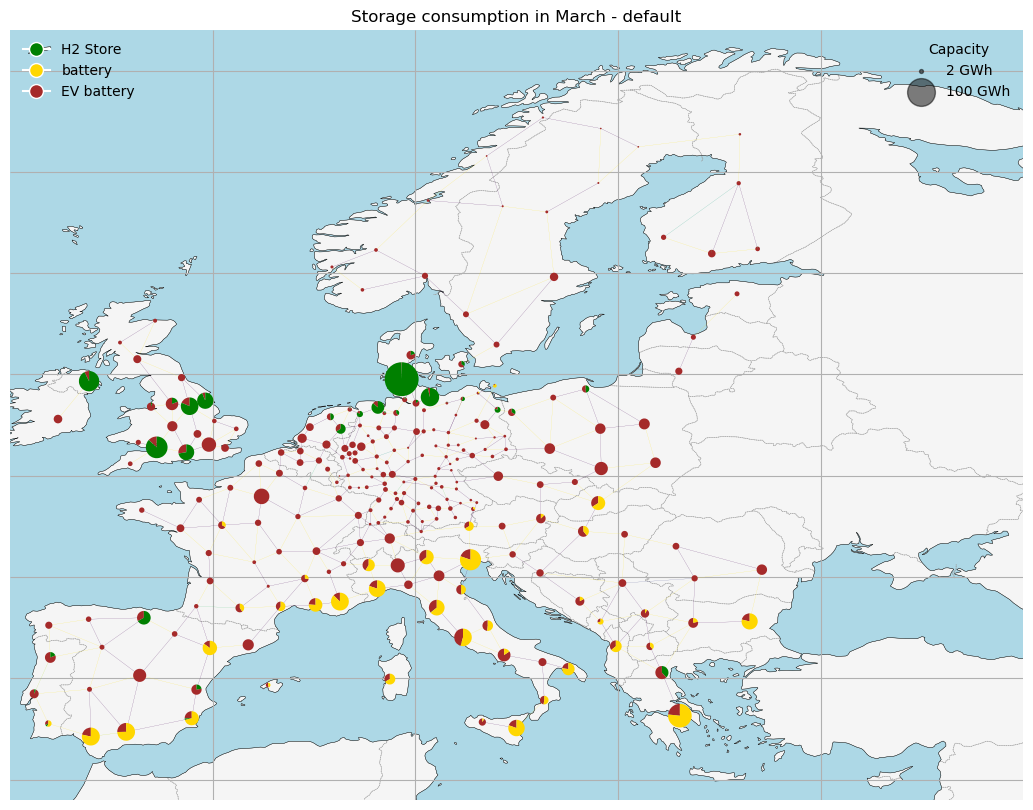

In [45]:
store = n2.stores[n2.stores.carrier.isin(["H2 Store", "battery", "battery storage"])].assign(sto3=n2.stores_t.e.loc["2013-03"].mean()).groupby(["bus", "carrier"]).sto3.sum().div(1e3) #GWh
store = store.reset_index()

# Perform the regular expression extraction on the 'bus' column
store ['bus'] = store['bus'].str.extract(r'(\w+\s+\d+)', expand=False)

# Set the modified 'bus' column back as part of the multi-index
store = store.set_index(['bus', 'carrier'], drop=True)

series = store["sto3"]
series.index = series.index.set_levels(series.index.levels[1].str.replace('battery storage', 'EV battery'), level='carrier')



EUROPE_BOUNDS = [-10, 40, 34, 72]
#carriers = ["H2 Electrolysis", "SMR CC", "SMR"]
carriers = ["H2 Store", "battery", "EV battery"]

colors = ["green", "gold", "brown"]

line_loading = n2.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

# Create a map with the PlateCarree projection centered on Europe

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.LAND, linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linestyle=':', color="grey", linewidth=0.5)


n2.plot(ax=ax,margin=0.25,
    bus_sizes=series/200,
    bus_colors={"H2 Store": "green", "battery":"gold", "EV battery": "brown"},
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="viridis",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    )

# Create legend for the energy mix size
for size in [2, 100]:  
    ax.scatter([], [], c='k', alpha=0.5, s=size * 4,
               label=str(size) + ' GWh',  
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)


ax.legend(loc='upper right', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#plt.legend()
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Set extent for Europe
ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())

plt.title('Storage consumption in March - default')

plt.show()


In [43]:
store.min()

sto3    0.000002
dtype: float64

In [23]:
DE_regions = gpd.read_file(r"./gadm_410-levels-ADM_1-DEU.gpkg")
DE_regions = DE_regions.drop(["GID_0", "GID_1", "COUNTRY"],axis=1)
DE_regions["centroid"] = DE_regions["geometry"].centroid

DE_regions

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_46393/3774344237.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  DE_regions["centroid"] = DE_regions["geometry"].centroid


NAME_1                                           geometry  \
0        Baden-Württemberg  MULTIPOLYGON (((8.35002 47.57062, 8.34778 47.5...   
1                   Bayern  MULTIPOLYGON (((11.41009 47.49540, 11.41005 47...   
2                   Berlin  MULTIPOLYGON (((13.50022 52.61379, 13.49855 52...   
3              Brandenburg  MULTIPOLYGON (((13.32220 51.43674, 13.32402 51...   
4                   Bremen  MULTIPOLYGON (((8.67501 53.17805, 8.67532 53.1...   
5                  Hamburg  MULTIPOLYGON (((10.17575 53.71111, 10.17562 53...   
6                   Hessen  MULTIPOLYGON (((8.88614 49.41698, 8.88546 49.4...   
7   Mecklenburg-Vorpommern  MULTIPOLYGON (((11.56936 53.16780, 11.56944 53...   
8            Niedersachsen  MULTIPOLYGON (((10.36772 51.55516, 10.36846 51...   
9      Nordrhein-Westfalen  MULTIPOLYGON (((6.57956 50.37709, 6.57518 50.3...   
10         Rheinland-Pfalz  MULTIPOLYGON (((7.64112 49.05281, 7.63539 49.0...   
11                Saarland  MULTIPOLYGON (((7.19729 49.11891, 7.19703 49.1...   
12                 Sachsen  MULTIPOLYGON (((12.35469 50.24796, 12.35507 50...   
13          Sachsen-Anhalt  MULTIPOLYGON (((12.24043 50.96210, 12.24105 50...   
14      Schleswig-Holstein  MULTIPOLYGON (((10.51093 53.37207, 10.50681 53...   
15               Thüringen  MULTIPOLYGON (((11.25325 50.27047, 11.25328 50...   

                     centroid  
0    POINT (9.04909 48.53753)  
1   POINT (11.42000 48.94784)  
2   POINT (13.40185 52.50153)  
3   POINT (13.39777 52.47288)  
4    POINT (8.74464 53.19772)  
5   POINT (10.02079 53.54638)  
6    POINT (9.03105 50.60322)  
7   POINT (12.55396 53.75402)  
8    POINT (9.15923 52.76588)  
9    POINT (7.56208 51.47971)  
10   POINT (7.44911 49.91369)  
11   POINT (6.95314 49.38437)  
12  POINT (13.34857 51.05233)  
13  POINT (11.70068 52.01318)  
14   POINT (9.81008 54.18288)  
15  POINT (11.02488 50.90387)

/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


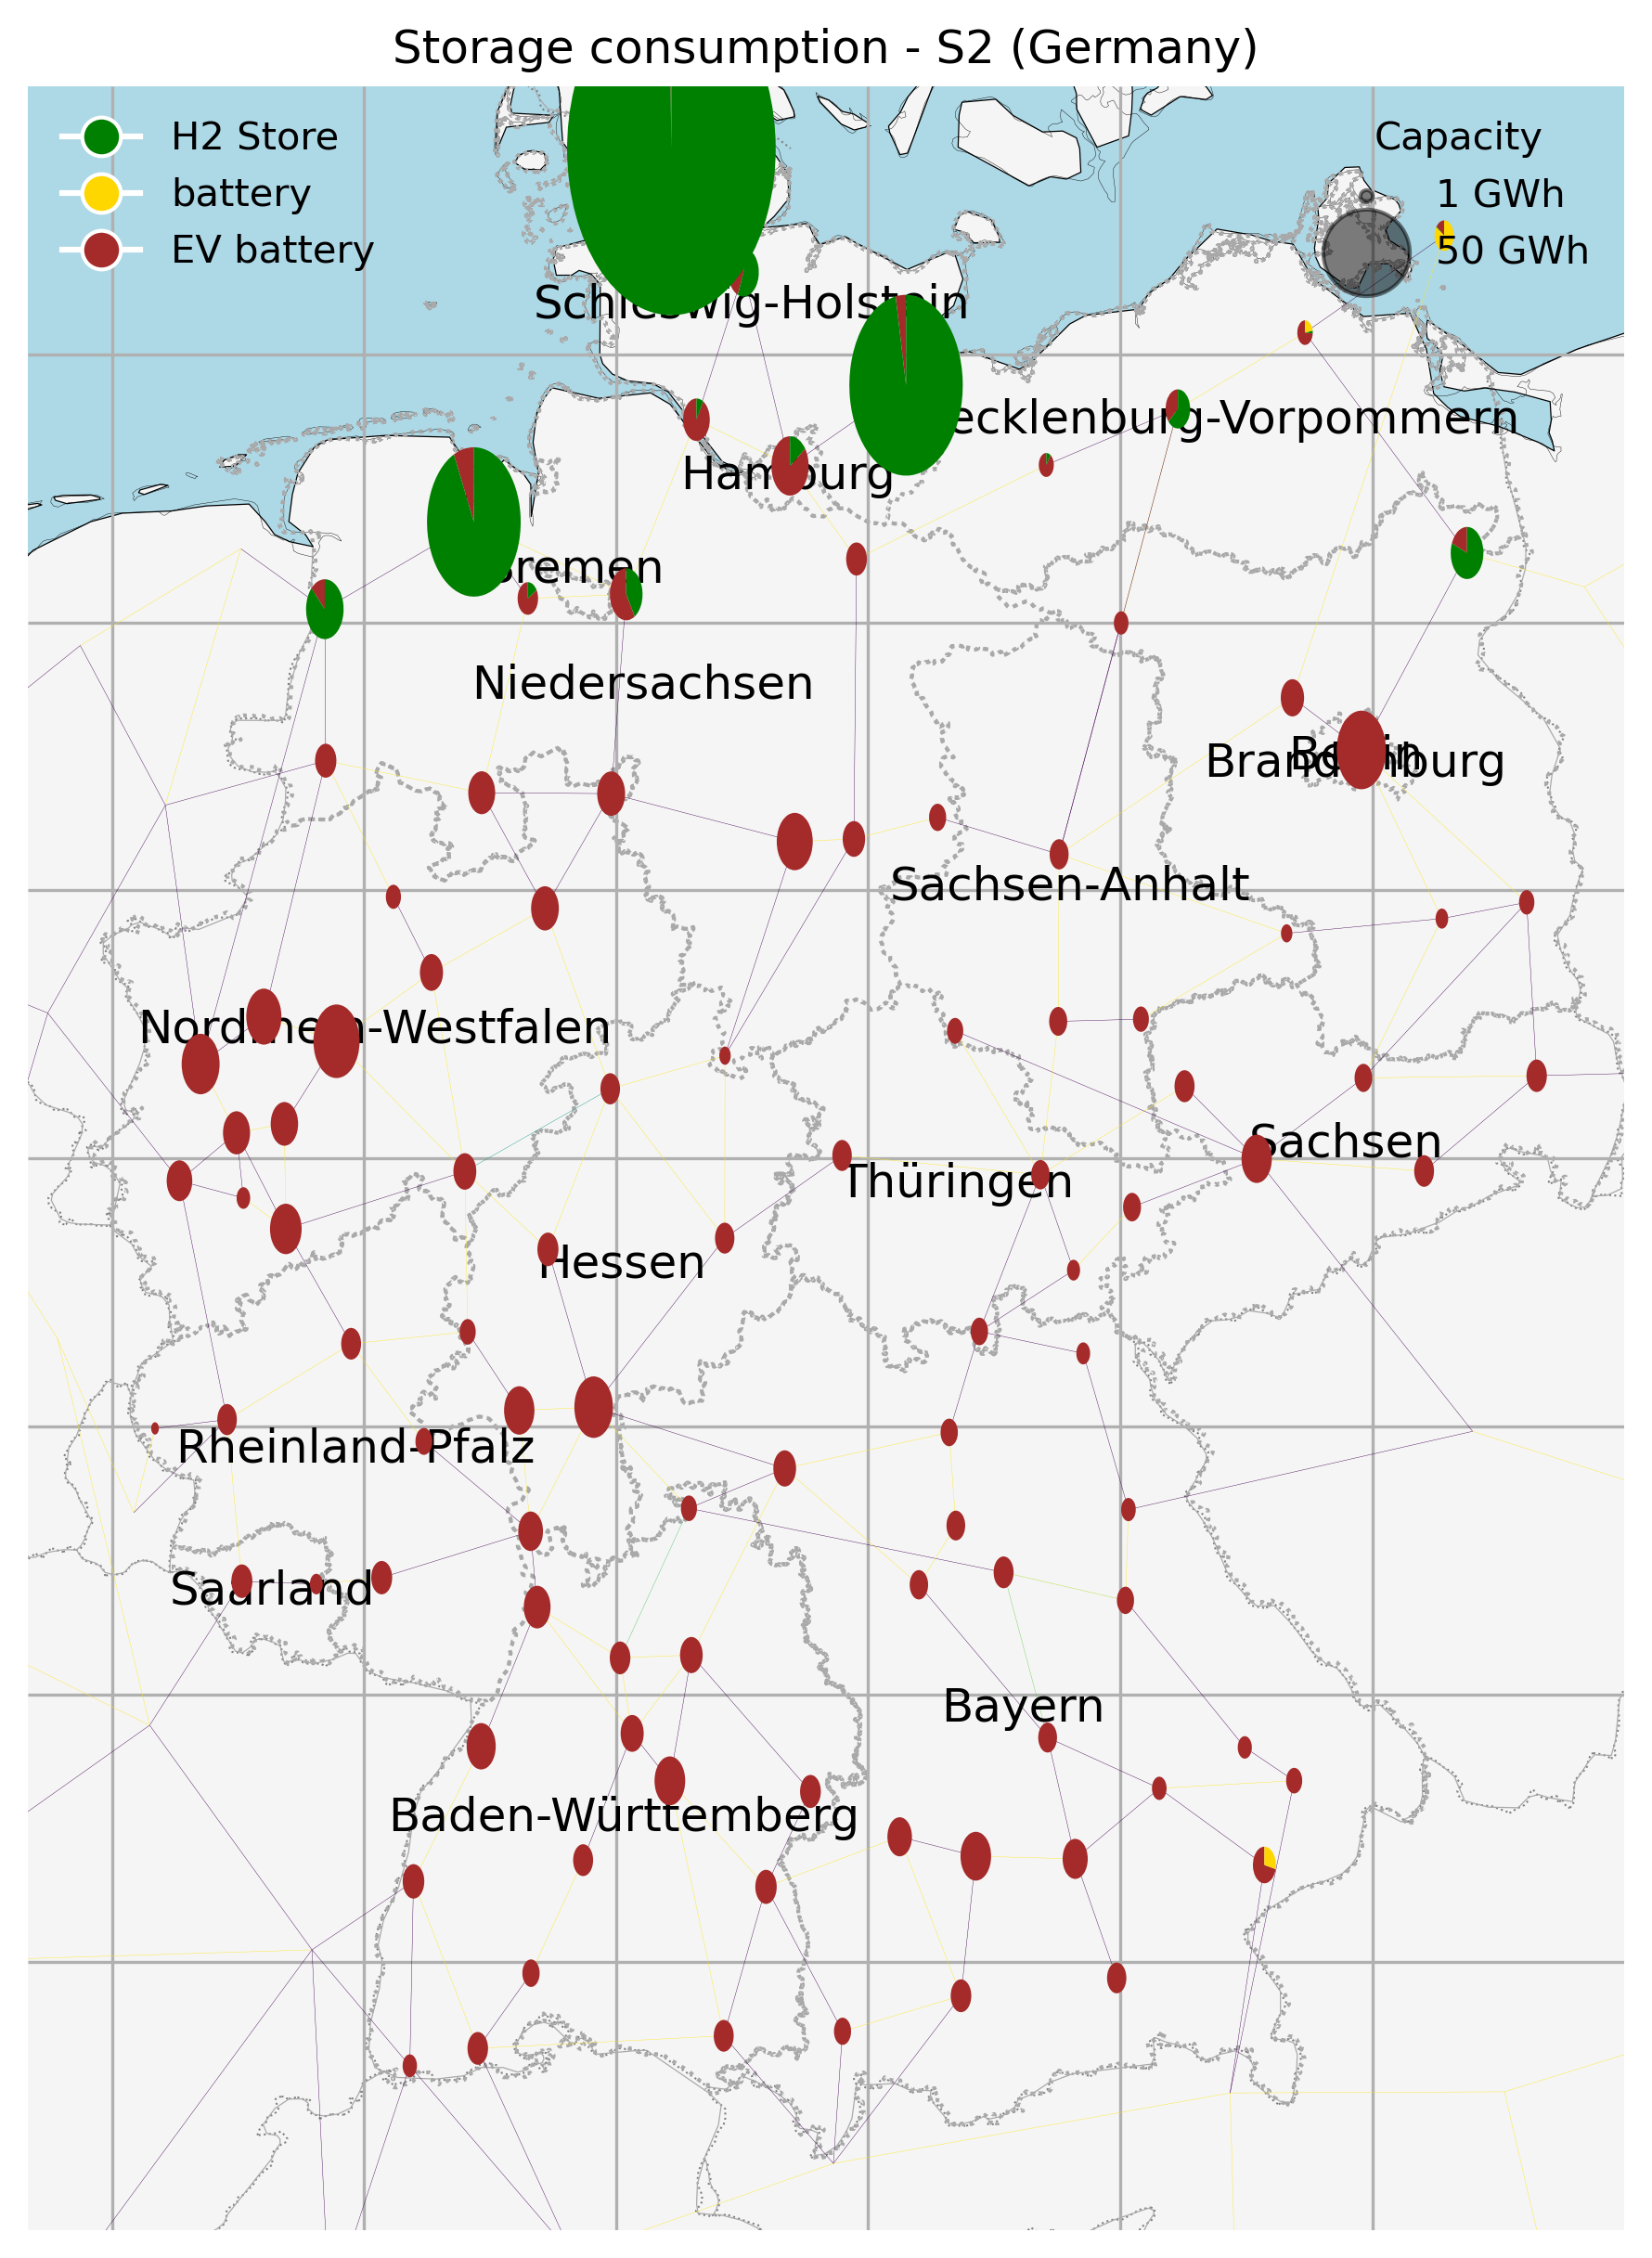

In [27]:
store = n2.stores[n2.stores.carrier.isin(["H2 Store", "battery", "battery storage"])].assign(sto3=n2.stores_t.e.mean()).groupby(["bus", "carrier"]).sto3.sum().div(1e3).filter(like="DE") #GWh
store = store.reset_index()

# Perform the regular expression extraction on the 'bus' column
store ['bus'] = store['bus'].str.extract(r'(\w+\s+\d+)', expand=False)

# Set the modified 'bus' column back as part of the multi-index
store = store.set_index(['bus', 'carrier'], drop=True)

series = store["sto3"]
series.index = series.index.set_levels(series.index.levels[1].str.replace('battery storage', 'EV battery'), level='carrier')



EUROPE_BOUNDS = [5.5, 15, 47, 55]
#carriers = ["H2 Electrolysis", "SMR CC", "SMR"]
carriers = ["H2 Store", "battery", "EV battery"]

colors = ["green", "gold", "brown"]

line_loading = n2.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

# Create a map with the PlateCarree projection centered on Europe

fig = plt.figure(figsize=(15, 10),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.LAND, linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linestyle=':', color="grey", linewidth=0.5)


n2.plot(ax=ax,margin=0.25,
    bus_sizes=series/500,
    bus_colors={"H2 Store": "green", "battery":"gold", "EV battery": "brown"},
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="viridis",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    )

boundary_style = {'edgecolor': 'darkgray', 'linestyle': ':', 'linewidth': 1}
# Plot the German states boundaries
DE_regions.boundary.plot(ax=ax, **boundary_style)  

# Add state names to the plot
for idx, row in DE_regions.iterrows(): 
    name = row['NAME_1']
    centroid = row['centroid']
    ax.text(centroid.x, centroid.y, name, ha='center', va='center', fontsize=12, transform=ccrs.PlateCarree())


# Create legend for the energy mix size
for size in [1, 50]: 
    ax.scatter([], [], c='k', alpha=0.5, s=size * 10,
               label=str(size) + ' GWh', 
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)


ax.legend(loc='upper right', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#plt.legend()
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Set extent for Europe
#ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())
# Set the extent of the map to Germany
ax.set_extent([5.5, 15, 47, 55], crs=ccrs.PlateCarree())

plt.title('Storage consumption - S2 (Germany)')

plt.show()


In [33]:
store.sort_values(by="sto3")

sto3
bus    carrier                    
DE1 57 H2 Store           0.000002
DE1 29 H2 Store           0.000002
DE1 59 H2 Store           0.000002
DE1 54 H2 Store           0.000002
DE1 4  H2 Store           0.000002
...                            ...
DE1 49 battery storage    9.418077
DE1 4  battery storage   10.742079
DE1 56 H2 Store          36.097593
DE1 67 H2 Store          55.229925
DE1 72 H2 Store         191.903090

[306 rows x 1 columns]

/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


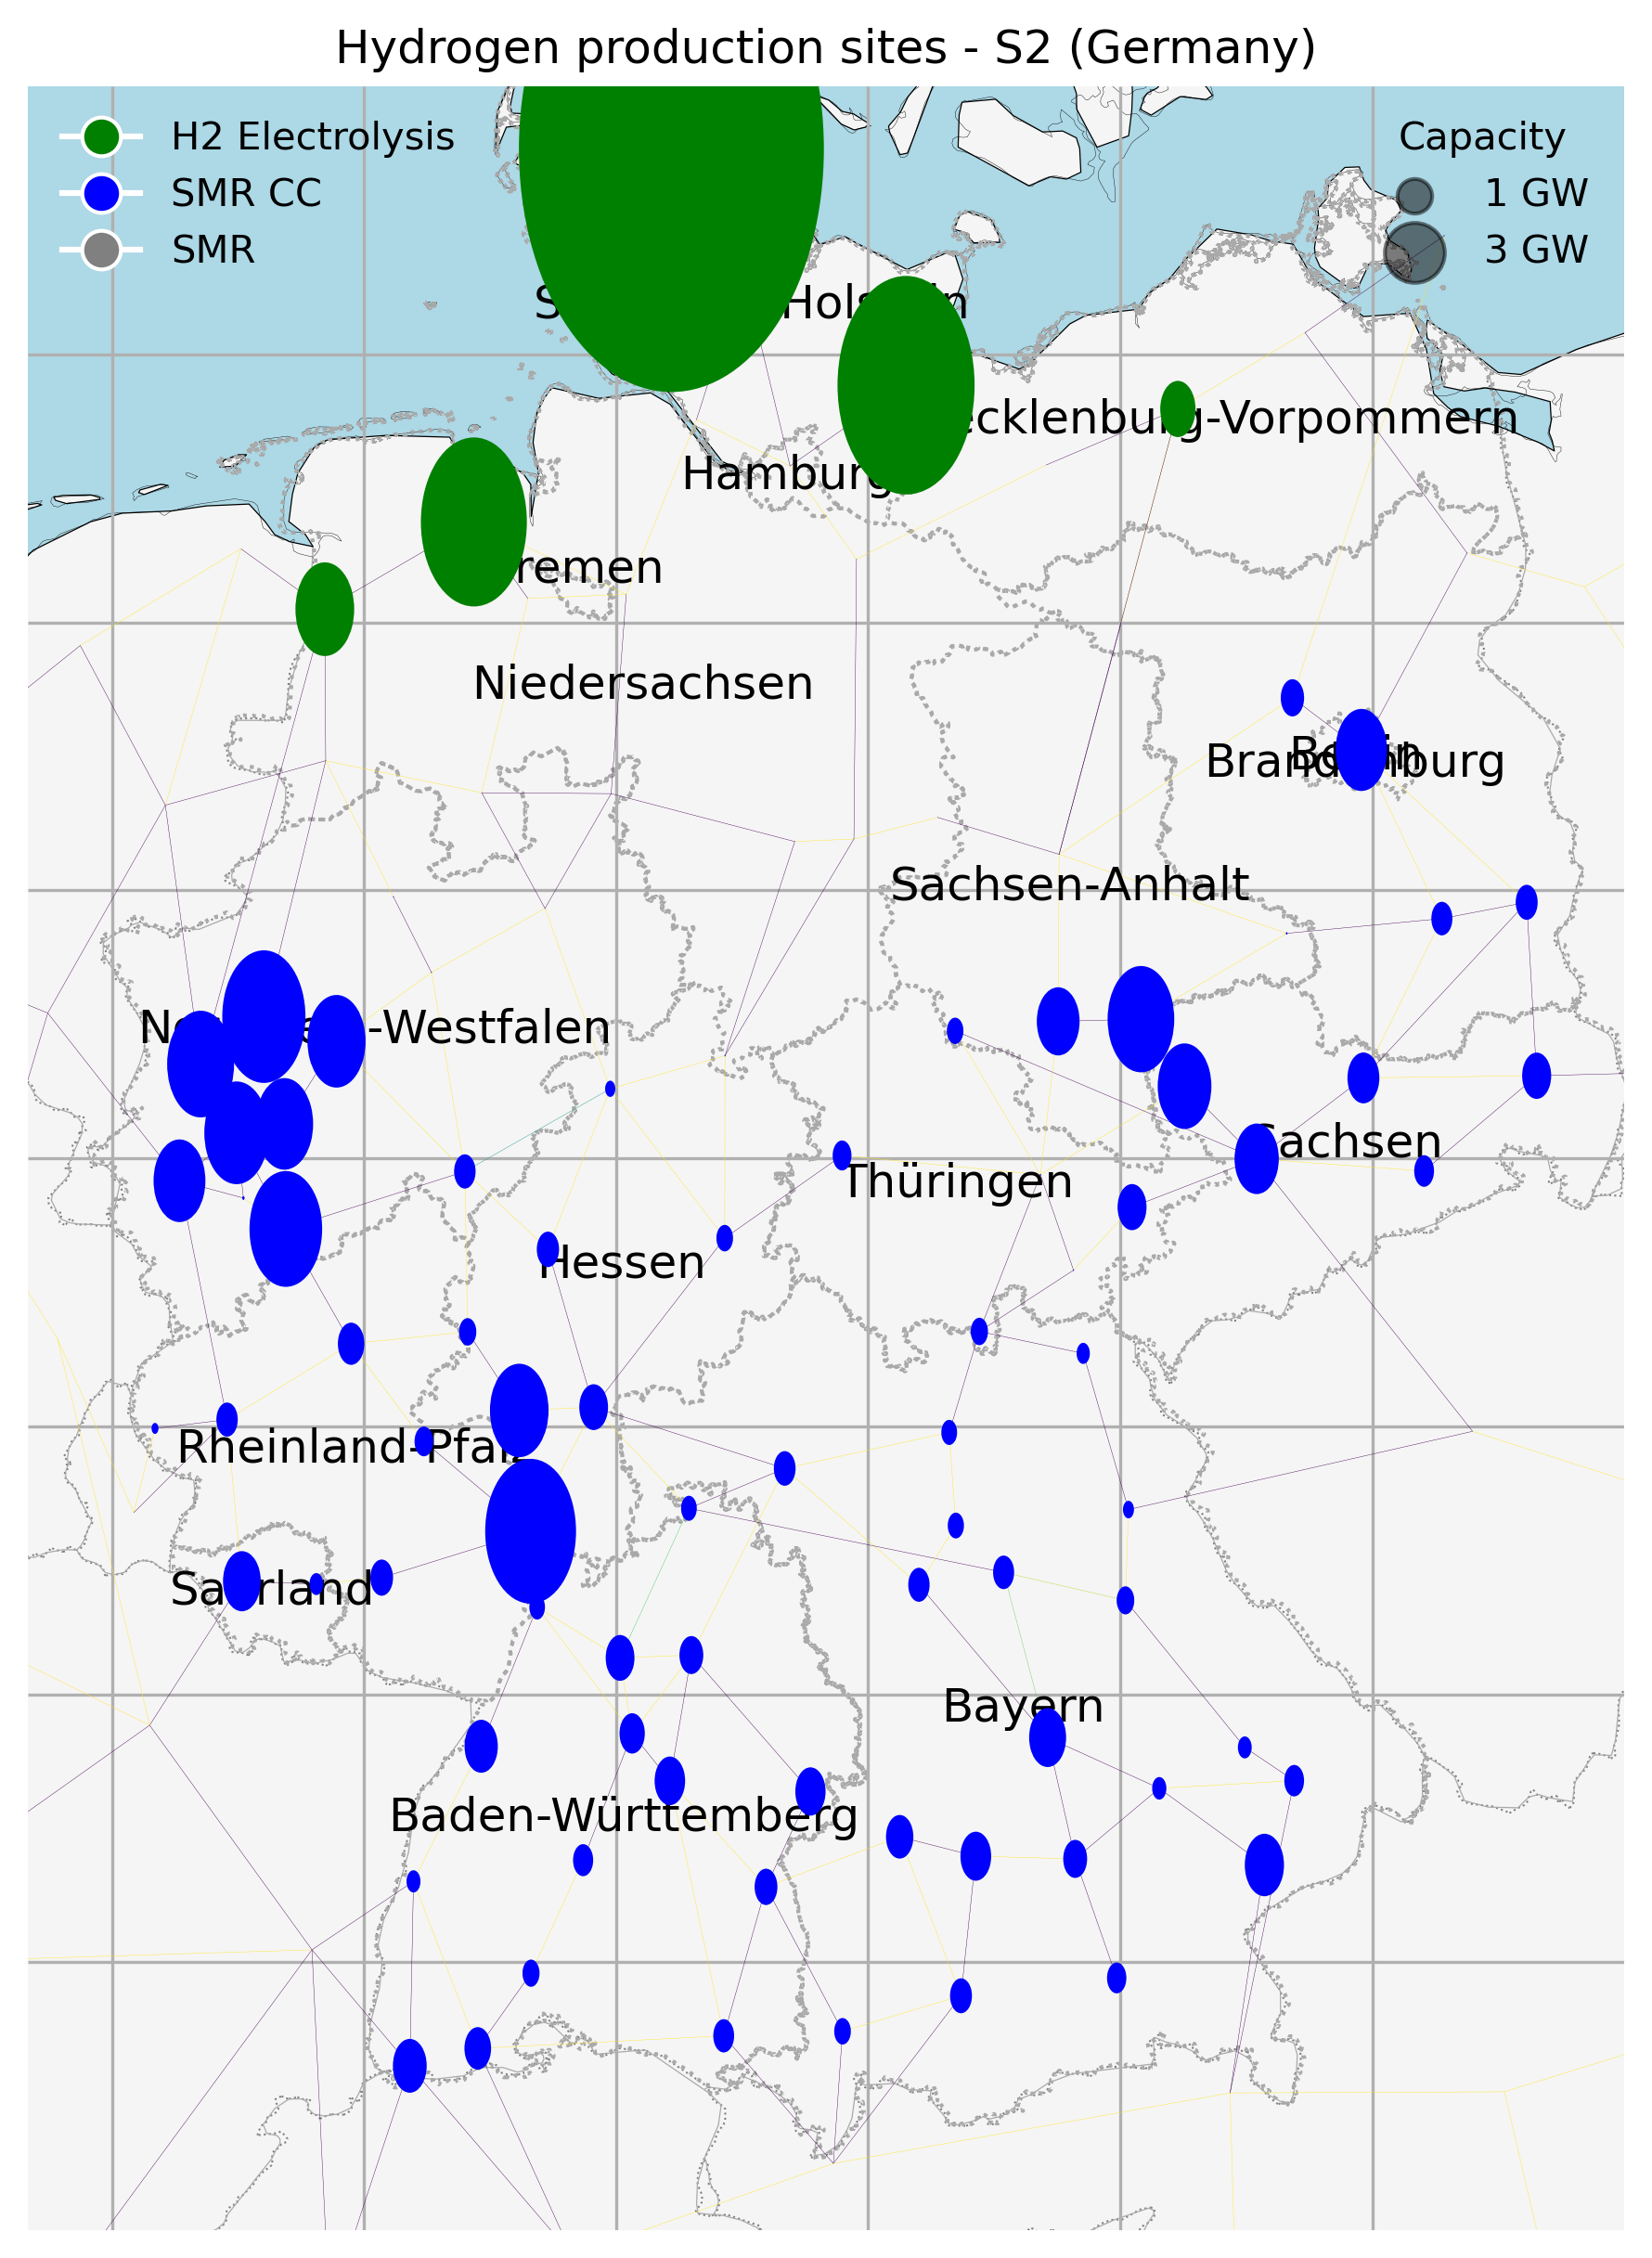

In [28]:
h2_sites2 = n2.links[n2.links.carrier.isin(["H2 Electrolysis", "SMR CC", "SMR"])].assign(l1=n2.links_t.p1.mean().abs()).groupby(["bus1", "carrier"]).l1.sum().filter(like="DE")
h2_sites2.index = h2_sites2.index.set_levels(h2_sites2.index.levels[0].str.replace(' H2', ''), level=0)

EUROPE_BOUNDS = [-15, 30, 30, 70]
carriers = ["H2 Electrolysis", "SMR CC", "SMR"]
colors = ["green", "blue", "gray"]

line_loading = n2.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

# Create a map with the PlateCarree projection centered on Europe

fig = plt.figure(figsize=(15, 10),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.LAND, linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linestyle=':', color="grey", linewidth=0.5)


n2.plot(ax=ax,margin=0.25,
    bus_sizes=h2_sites2/4000,
    bus_colors={"H2 Electrolysis": "green", "SMR CC": "blue", "SMR": "gray"},
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="viridis",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    )
boundary_style = {'edgecolor': 'darkgray', 'linestyle': ':', 'linewidth': 1}
# Plot the German states boundaries
DE_regions.boundary.plot(ax=ax, **boundary_style)  

# Add state names to the plot
for idx, row in DE_regions.iterrows():  
    name = row['NAME_1']
    centroid = row['centroid']
    ax.text(centroid.x, centroid.y, name, ha='center', va='center', fontsize=12, transform=ccrs.PlateCarree())

# Create legend for the energy mix size
for size in [1, 3]: 
    ax.scatter([], [], c='k', alpha=0.5, s=size * 80,
               label=str(size) + ' GW',  
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)


ax.legend(loc='upper right', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#plt.legend()
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Set extent for Europe
#ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())
ax.set_extent([5.5, 15, 47, 55], crs=ccrs.PlateCarree())

plt.title('Hydrogen production sites - S2 (Germany)')

plt.show()

In [32]:
h2_sites2.sort_values(ascending=False).head(10)

bus1    carrier        
DE1 72  H2 Electrolysis    3293.004254
DE1 67  H2 Electrolysis     665.284357
DE1 56  H2 Electrolysis     397.651538
DE1 70  SMR CC              292.102767
DE1 24  SMR CC              244.842652
DE1 80  SMR CC              186.769738
DE1 44  SMR CC              158.530143
DE1 88  SMR CC              157.335589
DE1 84  SMR CC              146.916879
DE1 5   H2 Electrolysis     122.173223
Name: l1, dtype: float64

/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


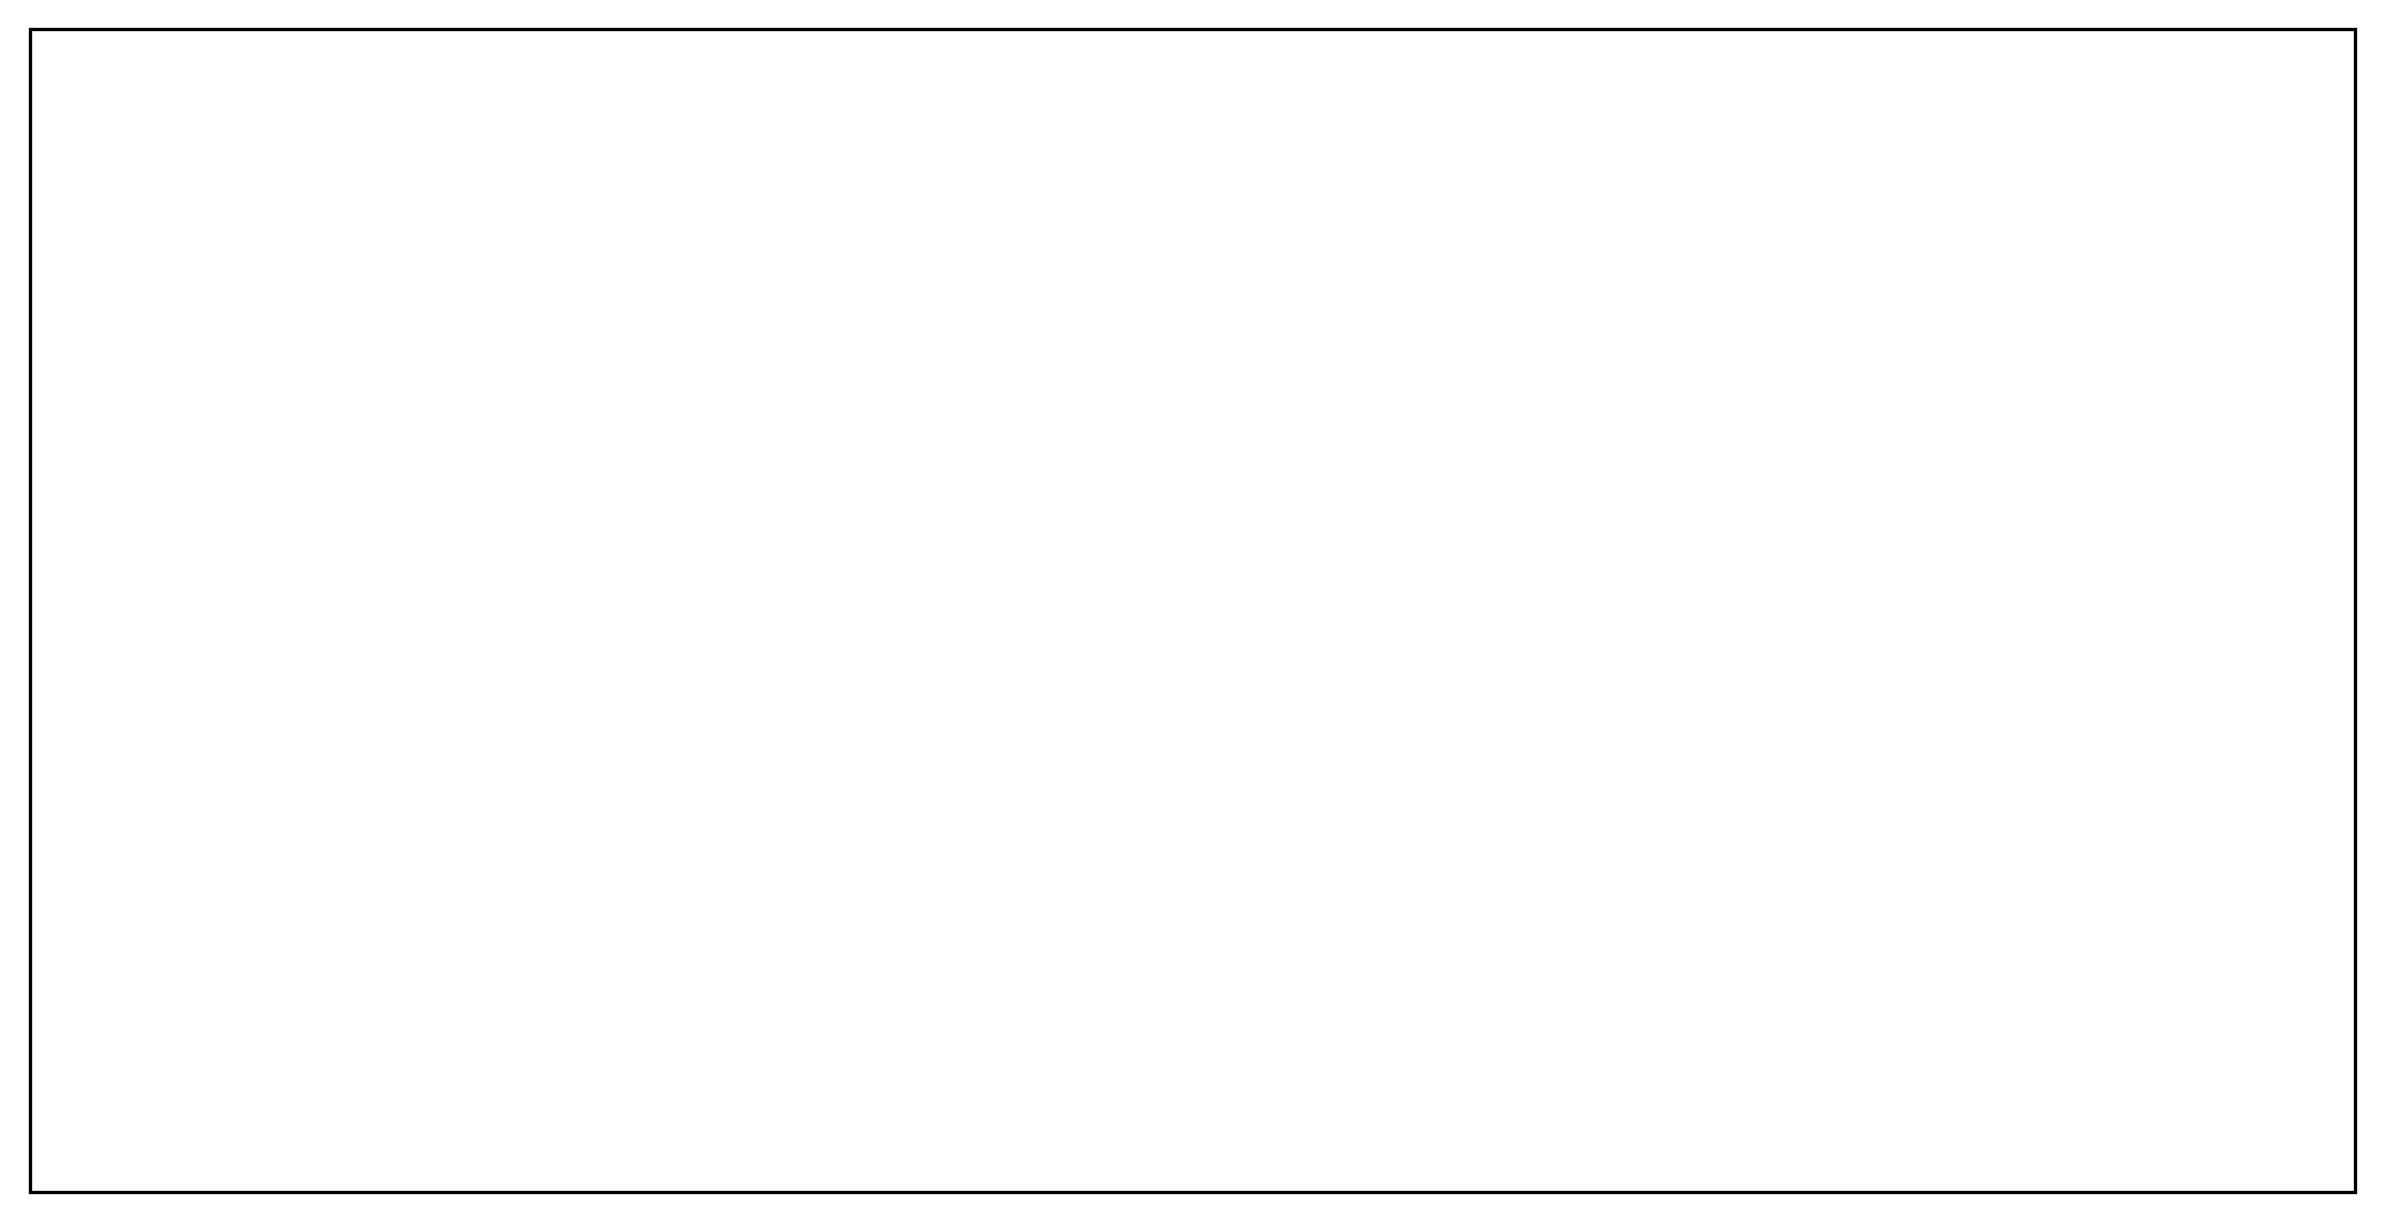

/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


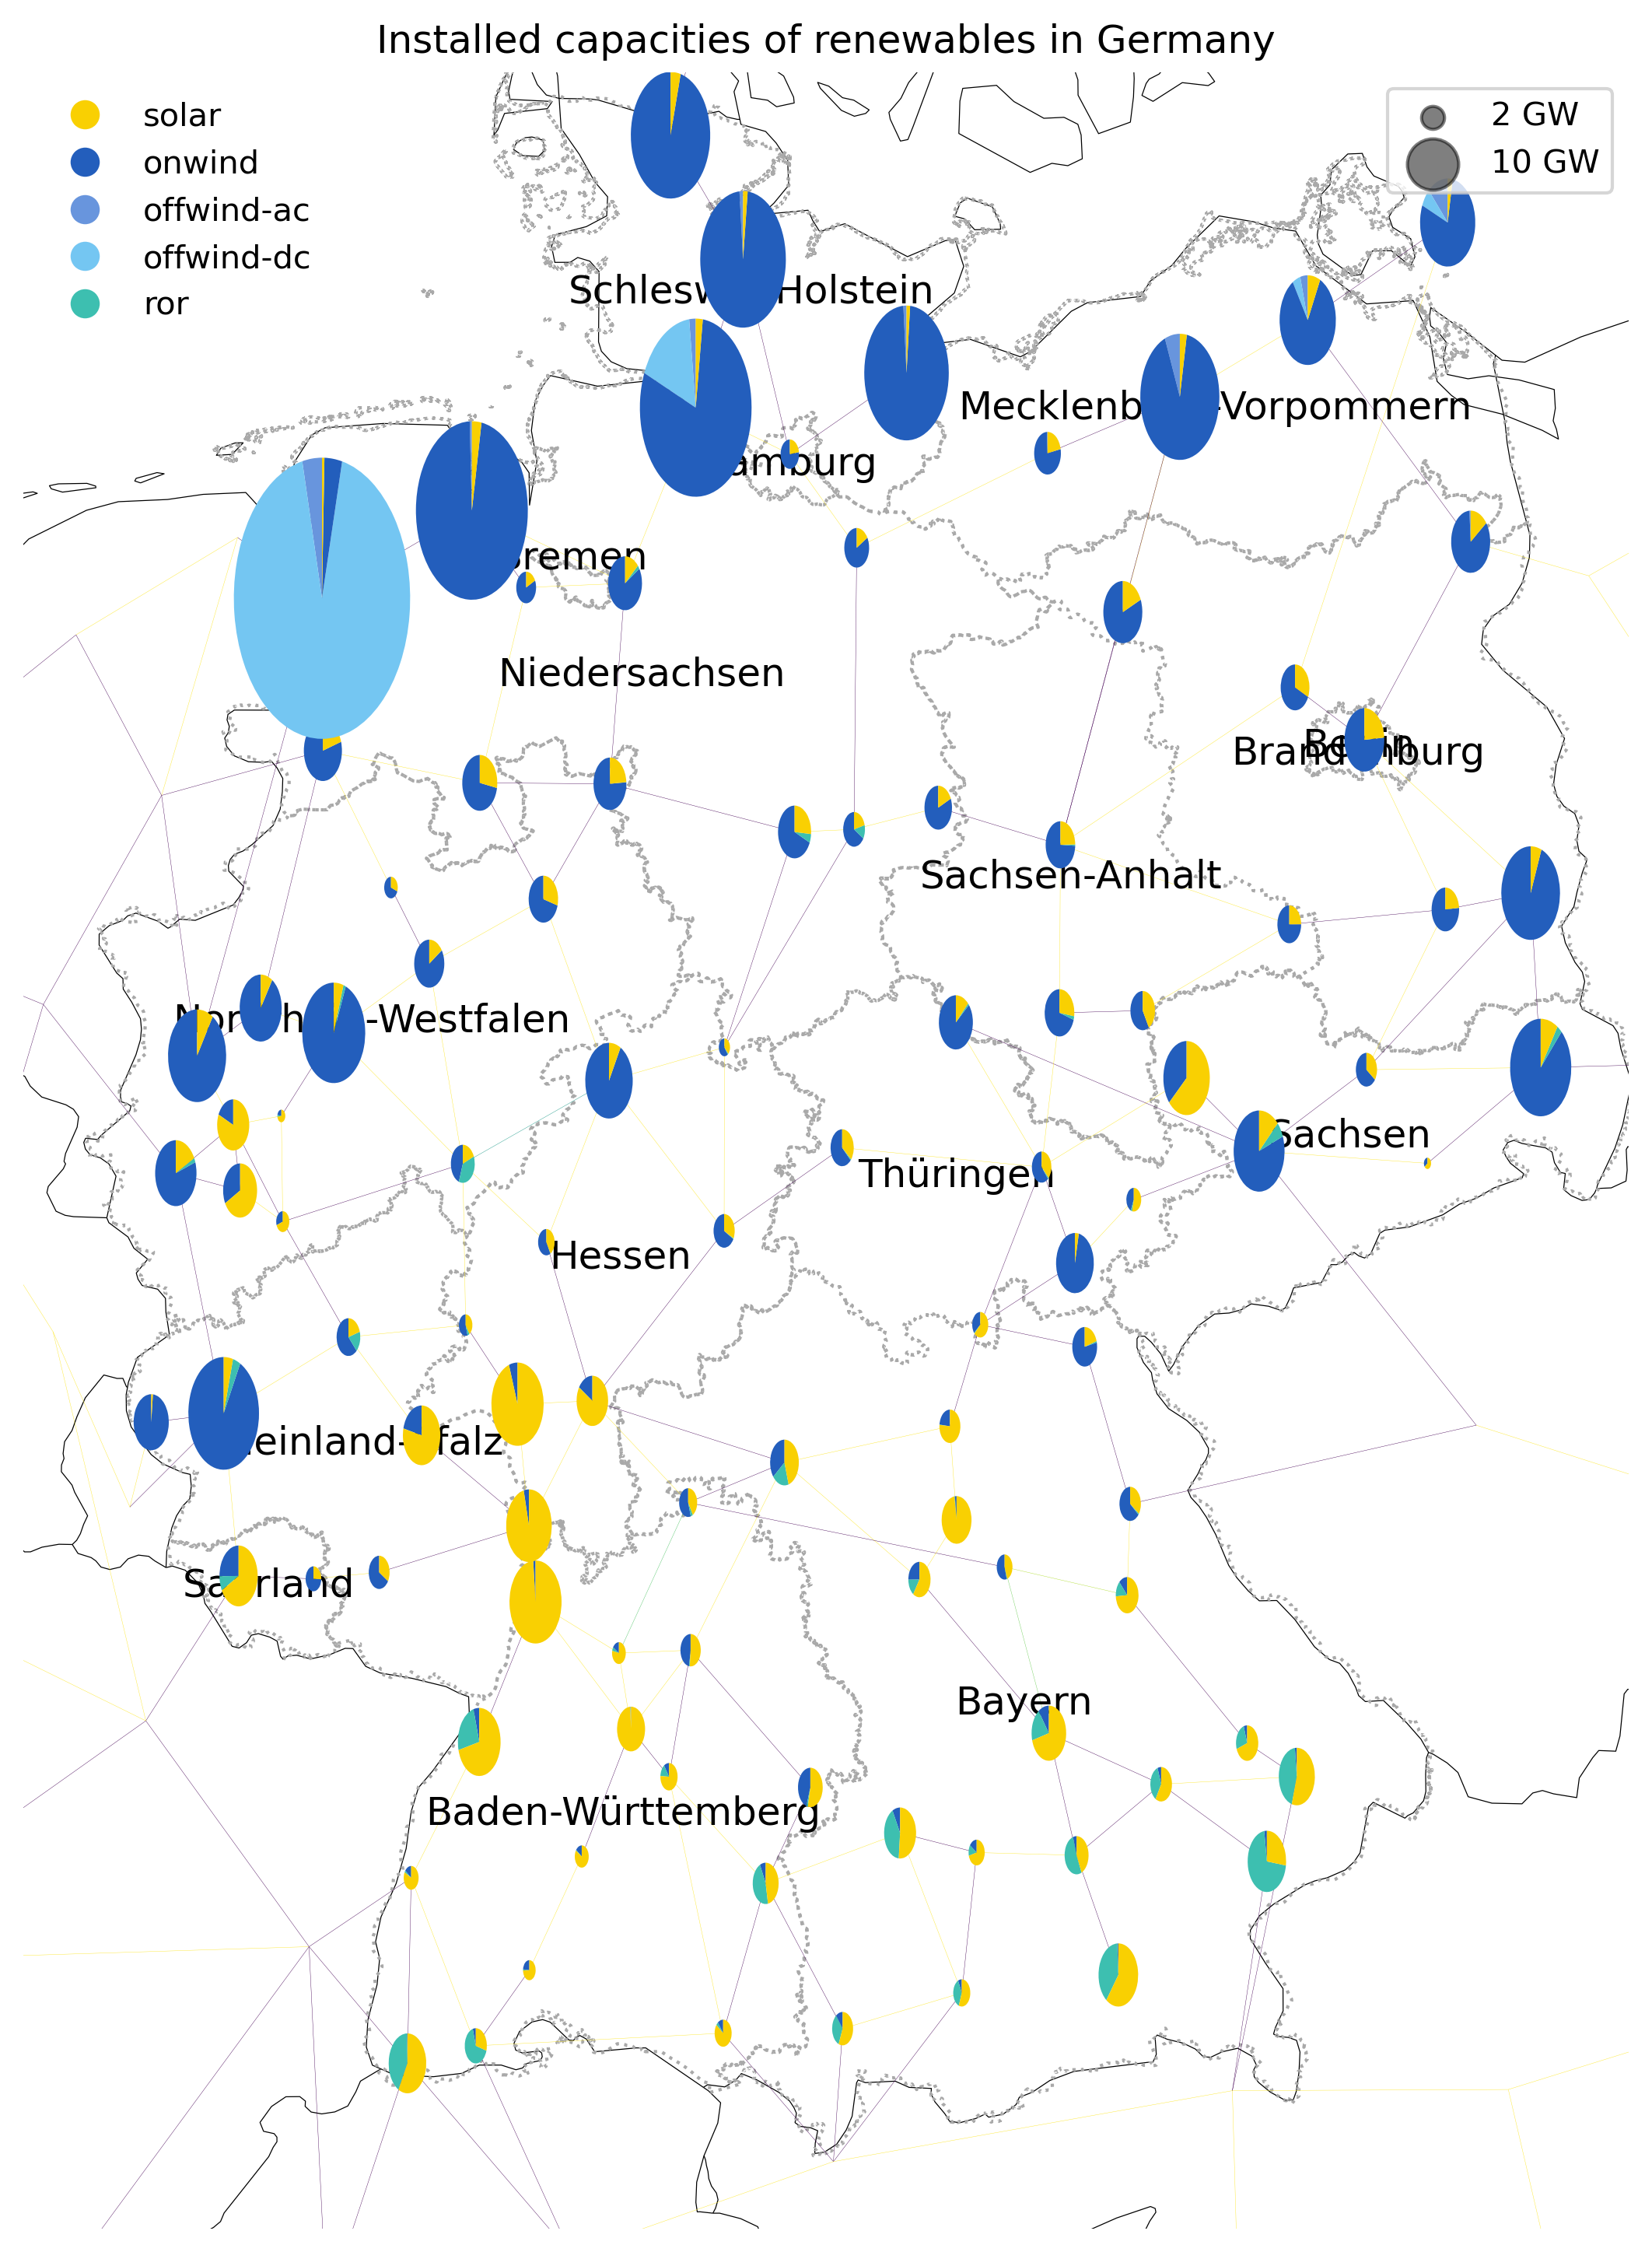

In [29]:
s4 = n2.generators[n2.generators.carrier.isin(["solar", "onwind", "offwind-ac","offwind-dc","ror", "gas", "oil"])].assign(g4=n2.generators_t.p.mean()).groupby(["bus", "carrier"]).g4.sum().filter(like="DE")
s4_filtered = s4[~s4.index.get_level_values('bus').isin(['EU oil', 'EU gas'])]

# Define the boundary style once, since it will be the same for each subplot
boundary_style = {'edgecolor': 'darkgray', 'linestyle': ':', 'linewidth': 1}
#EUROPE_BOUNDS = [-10.0, 30.0, 35.0, 30.0]
carriers = ["solar", "onwind", "offwind-ac", "offwind-dc","ror"]
#colors = ["#f9d002", "#235ebc", "#4adbc8"]
#colors = ["gold", "dodgerblue", "navy", "blue", "cyan"]
colors=['#f9d002','#235ebc','#6895dd','#74c6f2','#3dbfb0']
line_loading = n2.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

fig = plt.figure(figsize=(10, 12), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())

# Create a map with the PlateCarree projection centered on Europe
fig, ax = plt.subplots(figsize=(10, 12),
                       subplot_kw=dict(projection=ccrs.PlateCarree()),dpi=300)


# Add features to the map
#ax.add_feature(cfeature.LAND.with_scale('50m'))
#ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
#ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')

n2.plot(ax=ax,margin=1,
       bus_sizes=s4_filtered/35000,
        line_colors=line_loading,
        line_norm=norm,
        line_cmap="viridis",
        line_widths=0.1,
        link_widths=0)

# Plot the German states boundaries
DE_regions.boundary.plot(ax=ax, **boundary_style)  
# Add state names to the plot
for idx, row in DE_regions.iterrows(): 
    name = row['NAME_1']
    centroid = row['centroid']
    ax.text(centroid.x, centroid.y, name, ha='center', va='center', fontsize=12, transform=ccrs.PlateCarree())        

# Create legend for the energy mix size
for size in [2, 10]: 
    ax.scatter([], [], c='k', alpha=0.5, s=size * 25,
               label=str(size) + ' GW', 
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)
# Modify this part to create circle patches for the legend
#legend_elements = [mpatches.Circle((0, 0), radius=5, color=color, label=carrier)
#                   for carrier, color in zip(carriers, colors)]

#add_legend_patches(
#    ax, colors, carriers, legend_kw=dict(frameon=False, bbox_to_anchor=(0, 1))
#)

ax.legend(loc='lower left', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
plt.legend()
# Set extent for Europe
#ax.set_extent([-15, 30, 30, 70], crs=ccrs.PlateCarree())
# Set the extent of the map to Germany
ax.set_extent([5.5, 15, 47, 55], crs=ccrs.PlateCarree())

plt.title('Installed capacities of renewables in Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()